In [1]:
## Bouncing Packet Locator Script

# Date Created: 05/15/23 (Original Script, in MATLAB)
# Date Created: 01/03/24 (This Script)
# Last Modified: 02/04/24

# Author: Max Feinland for Blum Research Group, LASP

# Inputs: start date, end date

# Description: complete driver script. The user will be prompted to specify the dates 
# they would like to see. This script will then print out and plot all of the 
# microbursts found in the specified time period.

# housekeeping
import sys
import pandas as pd
import numpy as np
import spacepy.datamodel
import spacepy.time as spt
from datetime import datetime, timedelta
import dateutil.parser
from IRBEM import MagFields
import sampex
import matplotlib.pylab as plt
import matplotlib.dates as dates
from scipy.signal import find_peaks, peak_widths
import copy
import time
import stopit

In [2]:
## O'Brien

# Date created: 3/21/23 (in MATLAB)
# or 01/04/24 in Python
# Last modified: 02/04/24 (to fix a STUPID indexing issue, smh)
# Author: Max Feinland for Blum Research Group, LASP

# Inputs: sampex package HILT object

# Outputs: starting & ending time of each microburst, plus time intervals

def obrien(data):
    N20 = data['counts'] # count rate sampled every 20 ms
    time20 = data['time'] # time every 20 ms

    # I'm sure there's a more efficient way to do this, but I don't know it
    df = pd.DataFrame({'time': data['time'], 'counts': data['counts']})

    df.set_index('time', inplace=True) # set time column as the index

    # resample the dataframe to 100 ms intervals and sum the counts in each interval
    N100 = df.resample('100ms').sum()

    A500 = N100.rolling(5, center=True).mean() # 5-observation centered rolling mean (over 500 ms)

    condition = np.divide((N100.counts - A500.counts), np.sqrt(1 + A500.counts)) # O'Brien et al 2003
    
    ns = np.argwhere(condition > 10)
    ns = [item[0] for item in ns]

    epsilon = 10; # if two flagged indices are spaced less than this distance apart, 
    # they are probably part of the same microburst

    # initializing
    starts = []
    ends = []

    dn = np.diff(ns) # difference in time between instances of the condition being true

    # finding extended periods of the condition being true
    for i in np.arange(1,len(dn)-10):
        if dn[i] < epsilon and dn[i+1] < epsilon and dn[i-1] >= epsilon: # start condition
            starts.append(ns[i])
            for j in np.arange(i+1, len(dn)-1):
                if dn[j] < epsilon and dn[j+1] >= epsilon:
                    ends.append(ns[j]) # end condition
                    break
        elif dn[i] <= epsilon and i == 1: # start condition (edge case)
            starts.append(ns[i])
            for j in np.arange(i+1, len(dn-1)):
                if dn[j] <= epsilon:
                    ends.append(ns[j])
                    break
        elif i == len(dn): # end condition (edge case)
            ends.append(ns[i])

    if len(starts) > len(ends):
        ends.append(starts[len(starts)-1] + 10)
        
    starts = [x - 2 for x in starts] # pad with 0.2 seconds 
    ends = [x + 10 for x in ends] # pad with 1 second


    def changeCadence(time20, times100):
        # times100 is the list of timestamps for whatever it is: starts, ends, ns
        # times20 is the entire list of time20 for the day in question
        try:
            # try list comprehension first, it's faster
            idx20 = [time20.get_loc(tstmp) for tstmp in times100] 
        except: 
            idx20 = [] # clear and start over
            idx20 = [np.abs((time20 - target).values).argmin() for target in times100] 
            # if a timestamp is missing from time20,
            # you will have to find the minimum timestamp (that is closest in time)
        return idx20

    # reverting indices to 20 ms cadence

    starts20 = changeCadence(time20, N100.index[starts])
    ends20 = changeCadence(time20, N100.index[ends])
    ns20 = changeCadence(time20, N100.index[ns])

    # yay, your output is ready!
    d = dict(); 
    d['st'] = starts20
    d['et'] = ends20
    d['ns'] = ns20
    
    return d

In [3]:
def tsyganenko05(tstmp):
    
    # Author: Max Feinland, although Mike Shumko gets a lot of credit for the skeleton
    # Purpose: Calculates bounce period from T05 model.
    
    # If all of the preliminary conditions checked are true, the T05 model
    # will be called to check if the bounce period is within tolerance.
    
    # Also pulls attitude data. This saves some time, since you won't need to download
    # the attitude data otherwise.
    
    a = sampex.Attitude(tstmp) # attitude data (thanks Mike!)
    a.load()
    # change this for your needs. Of course, this pathing is for my machine.
    omniLoc = 'C:/Users/maxim/.spacepy/data/omnidata.h5'
    omniData = spacepy.datamodel.fromHDF5(omniLoc)
    omniT = np.array([dateutil.parser.parse(i.decode()) for i in omniData['UTC']])
    idx = np.where(tstmp >= omniT)[0][-1] # find relevant omni index
    T05Keys = ['Dst', 'Pdyn', 'ByIMF', 'BzIMF', 'W1', 'W2', 'W3', 'W4', 'W5', 'W6']
    maginput05 = {}
    maginput = {}

    X = {}
    # find relevant attitude index
    a_idx = np.where(tstmp >= a['time'])[0][-1]
    # X is the time & location of the particle (lla)
    X['dateTime'] = tstmp.strftime('%Y-%m-%d %H:%M:%S.%f')
    X['x1'] = a['Altitude'][a_idx]
    X['x2'] = a['GEO_Lat'][a_idx]
    X['x3'] = a['GEO_Long'][a_idx]
    # These are returned for data processing reasons (later on). Not necessary for the model
    L = a['L_Shell'][a_idx]
    MLT = a['MLT'][a_idx]
    
    KE = 1000 # keV, true of all particles observed at SAMPEX

    #T05 model
    model05 = MagFields(options = [0,0,0,0,0], kext = 11)
    for i in T05Keys:
        maginput05[i] = float(omniData[i][idx])
    Tb = model05.bounce_period(X, maginput05, KE) # call model
    return Tb, X, L, MLT

In [4]:
def bouncingPackets(so, eo, h):
    # Date created: not sure. Sort of a Ship of Theseus thing. I originally created this in MATLAB
    # 04/25/23, but have no idea when it was created in Python, unfortunately. Likely Jan 2024.
    # Last modified: 02/29/2024
    # Purpose: takes intervals specified from the O'Brien algorithm and searches for consistently-spaced,
    # low-width-variance, decreasing, isolated peaks whose bounce periods 
    # match up with the expected values.
    
    
    # Intializing variables
    pksi = []
    st = []
    et = []
    
    per = []
    L = []
    X = []
    lat = []
    lon = []
    MLT = []
    TbT05 = []
    tb_check = []
    
    # load in HILT data
    t = h.times
    rate = h.counts
    # the "with" statement prevents excessive runtimes, at the expense of a couple of days' worth of data
    with stopit.ThreadingTimeout(60) as context_manager:
        for i in range(len(so)):

            interval = rate[so[i]:eo[i]] # define just one chunk of the rate data, taken from O'Brien
            maxdis = max(interval) - min(interval) # use to generate prominence requirement

            # finding peaks with a high enough prominence
            [pks, _] = find_peaks(interval, prominence=0.25*maxdis, distance=3)
            npks = list(so[i] + loc for loc in pks)
            pksi.extend(npks) # add to "pksi" list, to access later (plotting)

            loc = pd.to_datetime(t[npks])

            dloc = [loc[i + 1] - loc[i] for i in range(len(loc) - 1)] # peak spacing
            dloc = [x.total_seconds() for x in dloc]
            ddloc = np.diff(dloc) # change in peak spacing; must be sufficiently small, i.e.
            # the peaks must be very regularly spaced.

            if len(ddloc) >= 2:
                threshold = 0.06 # lowest allowable change in peak spacing/period

                # find a run of at least 2 indices that meet this criterion. That means 4 peaks
                indices = np.where(np.convolve(np.abs(ddloc) < threshold, \
                                               np.ones(2), mode='valid') == 2)[0]
                if len(indices) == 1: # if there is exactly one microburst
                    tstmp_start = loc[indices[0]] - pd.Timedelta(seconds=0.2)
                    tstmp_final = loc[indices[0]+3] + pd.Timedelta(seconds=0.2)
                    et.extend(np.where(t == tstmp_final)[0])
                    st.extend(np.where(t == tstmp_start)[0])
                elif len(indices) > 1:
                    for j in range(len(indices)-1):
                        # if you are looking at the first index and there is not a jump, that is a start time
                        if j == 0 and indices[j + 1] - indices[j] == 1:
                            tstmp_start = loc[indices[j]] - pd.Timedelta(seconds=0.2)
                            st.extend(np.where(t == tstmp_start)[0])
                        elif j == 0: # otherwise, nothing happens!
                            pass
                        # if previously, you were not in a consecutive streak, 
                        # but now you are, that is a start time
                        elif indices[j+1] - indices[j] == 1 and indices[j] - indices[j-1] > 1:
                            tstmp_start = loc[indices[j]] - pd.Timedelta(seconds=0.2)
                            st.extend(np.where(t == tstmp_start)[0])
                        # if previously, you were in a consecutive streak, but now you are not,
                        # that is an endtime
                        elif indices[j+1] - indices[j] > 1 and indices[j] - indices[j-1] == 1:
                            tstmp_final = loc[indices[j]+3] + pd.Timedelta(seconds=0.2)
                            et.extend(np.where(t == tstmp_final)[0])

                    # end condition if the previous one wasn't met
                    if len(st) > len(et):
                        tstmp_final = loc[indices[j]+3] + pd.Timedelta(seconds=0.2)
                        et.extend(np.where(t == tstmp_final)[0])

    # The variables st and et contain all intervals that satisfy the strict bounce period condition.
    # Now we will check the other conditions.
        
    # Check if timed out.
    if context_manager.state == context_manager.EXECUTED:
        st = np.sort(st)
        et = np.sort(et)
    
    elif context_manager.state == context_manager.TIMED_OUT:
        st = []
        et = []
        print("Timed out execution. Skipping this day.")

    final_st = []
    final_et = []
    finalpksi = []

    for k in range(len(st)):
        # Find all of the indices in the rate data corresponding to this interval.
        ok_range_for_this_index = np.arange(st[k], et[k]+1).tolist()
        # Find all the values in pksi that are contained within these indices.
        these_pk_indices = [index for index, value in enumerate(pksi) if value in ok_range_for_this_index]
        # 
        relative_pks = [pksi[x]-st[k] for x in these_pk_indices]
        current_per = np.mean(np.diff(relative_pks))*0.02 # mean period
        
        interval = rate[st[k]:et[k]]
        unq = len(np.unique(interval)) > 5
        if unq == True:
            try:
                widths = peak_widths(interval, relative_pks, rel_height=0.5)
                incrw = np.all(np.diff(widths[0]) >= -2)
                
                # Needed to make the condition "isol"
                desired_starttime = t[st[k]] - pd.Timedelta(seconds=3.5)
                idxs = np.abs(np.array(t, dtype='datetime64') - np.datetime64(desired_starttime)).argmin()
                interval2_start = idxs

                desired_endtime = t[et[k]] + pd.Timedelta(seconds=3.5)
                idxe = np.abs(np.array(t, dtype='datetime64') - np.datetime64(desired_endtime)).argmin()
                interval2_end = idxe
                interval2 = rate[interval2_start:interval2_end]

                interval = rate[st[k]:et[k]]
                maxdis = max(interval) - min(interval)
                [loc2, _] = find_peaks(interval2, prominence=0.25*maxdis, distance=3)
                intermediate_list = []
                intermediate_list = (st[k]-175 + loc2).tolist()
                all_pks_for_interval = [pksi[x] for x in these_pk_indices]
                for item in all_pks_for_interval:
                    if item in intermediate_list:
                        intermediate_list.remove(item)

                isol = len(intermediate_list) < 10
                
                # this is for the decreasing interpolation
                timestamps = t[st[k]:et[k]]
                timestamps = np.array(timestamps, dtype='datetime64')
                timedelta_index = pd.to_timedelta(timestamps - timestamps.astype('datetime64[D]'))
                intt = timedelta_index.total_seconds()

                peaks, _ = find_peaks(-interval, prominence=0.15 * np.ptp(interval))
                peaks = np.concatenate(([0], peaks, [len(interval) - 1]))

                vq = np.interp(intt, [intt[x] for x in peaks], [interval[x] for x in peaks])
                adj = interval - vq + np.min(interval)
                
#                 plt.figure()
#                 plt.plot(intt, adj, '--', label='adjusted')
#                 plt.plot(intt, interval, label='raw')
#                 plt.plot(intt[relative_pks], adj[relative_pks], 'd-')

                decr = np.sum(np.diff(adj[relative_pks])) < 0
#                 print(adj[relative_pks[1:]])
                passesMostConditions = isol and unq and incrw and decr
            except:
                passesMostConditions = False
        else:
             passesMostConditions = False


        # This is split up into two cases because the TbT05 calculation takes FOREVER to run.
        # So, the first three conditions must be true before the last one will be checked.
        if passesMostConditions == True:
            # print('Calling Tsyganenko 2005 model. This may take a while; please be patient.')
            [Tb, current_X, current_L, current_MLT] = tsyganenko05(t[st[k]])
            okper = (np.abs(current_per - Tb) < 0.15 or np.abs(current_per - Tb/2) < 0.1)

            per.append(current_per)
            L.append(current_L)
            MLT.append(current_MLT)
            TbT05.append(Tb)
            final_st.append(st[k])
            final_et.append(et[k])
            finalpksi.append(all_pks_for_interval)
            tb_check.append(okper)
            lat.append(current_X['x2'])
            lon.append(current_X['x3'])
    
    data = pd.DataFrame({'t': [h.times[x] for x in final_st], 'per': per, 'tb': TbT05, 'L': L, 
                     'MLT': MLT, 'lat': lat, 'lon': lon, 'okper': tb_check})
    return final_st, final_et, finalpksi, data



Welcome to the ChorusWaves search script.
Coded by Max Feinland for Blum Research Group, 2023-2024.
The most recently queried dates were January 01, 2003 to January 30, 2003.
Press o to set the first date as 1 after the last date of the last query.
Enter a start date formatted as "YYYY, MM, DD", or press r for the most recently queried dates: o
Enter an end date, or enter the number of days as an integer (from 1 to 30): 30

Downloaded hhrr2003031.txt.zip.
Running O'Brien algorithm...
Searching for bouncing packets...
No intervals found.

Downloaded hhrr2003032.txt.zip.
Running O'Brien algorithm...
Searching for bouncing packets...
1 interval found. Plotting now.


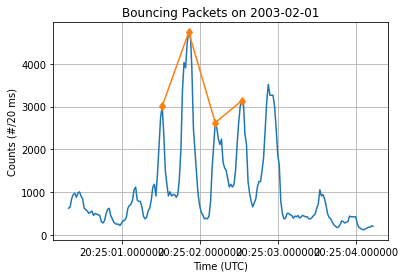


Downloaded hhrr2003033.txt.zip.
Running O'Brien algorithm...
Searching for bouncing packets...


In [ ]:
# The "main" script, if you will.
# Prompts the user for dates, with a number of options (mostly so my life is easier.)
# Runs O'Brien, then bouncingPackets. Plots the results and saves to a dataframe, which is then
# saved to a file.
# Date created: 01/04/2024
# Last modified: 02/29/2024
# Author: Max Feinland


print("Welcome to the ChorusWaves search script.", flush=True)
print("Coded by Max Feinland for Blum Research Group, 2023-2024.", flush=True)

# hilt_already_loaded = None
# print_yn = 1
# ## This is all for user input.

if 'first_day_d' in globals():
    fdo = first_day_d
    ldo = last_day_d
    f_fd = fdo.strftime("%B %d, %Y")
    f_ld = ldo.strftime("%B %d, %Y")
    if f_fd == f_ld:
        print(f"The most recently queried date was {f_fd}.", flush=True)
    else:
        print(f"The most recently queried dates were {f_fd} to {f_ld}.", flush=True)
    print("Press o to set the first date as 1 after the last date of the last query.")
    first_day = input("Enter a start date formatted as \"YYYY, MM, DD\", or press r for the most recently queried dates: ")
else:
    first_day = input("Enter a start date formatted as \"YYYY, MM, DD\": " )

if first_day == "r":
    try:
        first_day_d = fdo
        last_day_d = ldo
        if fdo == ldo:
            hilt_already_loaded = True # if you keep running the same day over and over, like I do, this saves time
    except:
        print("Looks like you cleared your old dates; can't use that command, sorry.")
elif first_day == "o":
    first_day_d = ldo + timedelta(days=1)
    last_day = input("Enter an end date, or enter the number of days as an integer (from 1 to 30): ")
    try:
        last_day = int(last_day)
        if last_day in np.arange(1, 31):
            last_day_d = first_day_d + timedelta(days = last_day - 1)
        else:
            print("Number of days not allowed. Please try again.")
            print("Zero days is not allowed for obvious reasons, and more than 30 are not recommended due to processing time.")
    except:
        try:
            last_day = last_day.split(", ")
            last_day_d = datetime(int(last_day[0]), int(last_day[1]), int(last_day[2]))
        except:
            print("Unrecognized command; could not execute.")
else:
    first_day = first_day.split(", ")
    first_day_d = datetime(int(first_day[0]), int(first_day[1]), int(first_day[2]))
    last_day = input("Enter an end date, or enter the number of days as an integer (from 1 to 30): ")
    try:
        last_day = int(last_day)
#         if last_day in np.arange(1, 31):
        last_day_d = first_day_d + timedelta(days = last_day - 1)
#         else:
#             print("Number of days not allowed. Please try again.")
#             print("Zero days is not allowed for obvious reasons, and more than 30 are not recommended due to processing time.")
    except:
        try:
            last_day = last_day.split(", ")
            last_day_d = datetime(int(last_day[0]), int(last_day[1]), int(last_day[2]))
        except:
            print("Unrecognized command; could not execute.")
date_list = [first_day_d + timedelta(days=i) for i in range((last_day_d - first_day_d).days + 1)]


print_yn = 1
hilt_already_loaded = None
# Now we are getting to the the function calls, etc

save_counter = 0
data = pd.DataFrame()
for day in date_list:
    formatted_date = day.strftime("%B %d, %Y")

    if print_yn == 1:
        print(f"\nCollecting data for {formatted_date}...")

    if hilt_already_loaded == True:
        pass
    else:
        h = sampex.HILT(day) # count rate data (thanks Mike!)
        h.load()

    if print_yn == 1:
        print("Running O'Brien algorithm...")

    d = obrien(h) # call O'Brien function

    so = d['st']
    eo = d['et']
    ns = d['ns']

    if print_yn == 1:
        print("Searching for bouncing packets...")

    [stt, ett, pksit, this_data] = bouncingPackets(so, eo, h)
    data = pd.concat([data, this_data], ignore_index=True)
    filename = "events_runonmar12.csv"
#     if np.floor(len(data) / 10) > save_counter:
#         data.to_csv(filename, sep=',', index=False, encoding='utf-8')
#         save_counter = save_counter + 1


    if print_yn == 1:
        if len(stt) == 0:
            print("No intervals found.")
        elif len(stt) == 1:
            print("1 interval found. Plotting now.")
        else:
            print(len(stt), "intervals were found. Plotting now.")

    for j in range(len(stt)):
        fig = plt.figure(j)
        ax = fig.add_subplot()
        plt.grid(True)

        ax.plot(h.times[stt[j]-50:ett[j]+75], h.counts[stt[j]-50:ett[j]+75])
        ax.plot(h.times[pksit[j]], h.counts[pksit[j]], marker='d')
        ax.xaxis.set_major_formatter(dates.DateFormatter('%H:%M:%S.%f')) 
        ax.set_xlabel('Time (UTC)')
#             ax.xaxis.label.set_color('white')
#             ax.yaxis.label.set_color('white')
        ax.set_ylabel('Counts (#/20 ms)')
        # ax.tick_params(colors='white', which='both')
        ax.set_title('Bouncing Packets on ' + h.times[stt[j]].strftime('%Y-%m-%d'))
        # ax.title.set_color('white')
        plt.show()
        if len(stt) == 1:
            plt_name = h.times[stt[j]].strftime('%Y%m%d') + '.jpg'
        else:
            plt_name = h.times[stt[j]].strftime('%Y%m%d') + "_" + str(j+1) + '.jpg'
        fig.savefig(plt_name)
import os.path
if os.path.isfile('./' + filename):
    data.to_csv(filename, mode='a', sep=',', index=False, header=False, encoding='utf-8')
else:
    data.to_csv(filename, sep=',', index=False, encoding='utf-8')

print('Script complete.')